# How Positional Embeddings Work

In modern transformer-based architectures, token sequences are processed in parallel rather than sequentially (as they were done in the older Recursive Neural Network (RNN) architectures). 
This provides a great performance boost as parallel operations always do. One key idea that enables this is positional encoding. 

Positional encodings incorporate position within the embedding. The model can thus learn to extract it and even compare embeddings to obtain the distance between them .

A formulation that is popularly used and was first introduced in the now famous Vaswani et. al. (2017) paper is given below:

$$
p_{i,2j} = sin(\frac{i}{10000^{2j/d}}) \\

p_{i,2j+1} = cos(\frac{i}{10000^{2j/d}})
$$

Where $i$ is the token position and $2j, 2j+1$ are adjacent embedding indices and $d$ is the embedding size. At first glance, this seems a bit strange. Why use sine and cosine? Why use different functions for adjacent positions? Why make sine and cosine frequencies decay for larger dimensions? 

I'll try to answer some of these questions.

## First, let's generate some sample embeddings 



In [68]:
sequence_length = 12 
embedding_length = 10 

import jax.numpy as jnp

def get_embedding_value(t, i):

    x = t / (100.0**(i/embedding_length))
    return x, jnp.where(i%2 == 0, jnp.sin(x), jnp.cos(x))

embeddings = jnp.zeros([sequence_length, embedding_length])
for i in range(sequence_length):
    for j in range(embedding_length):
        e = get_embedding_value(i, j)
        embeddings = embeddings.at[i,j].set(e[1])

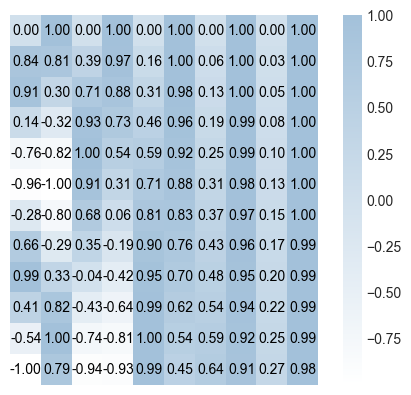

In [70]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from matplotlib.colors import LinearSegmentedColormap

pastel_cmap = LinearSegmentedColormap.from_list('pastel_blue', ['white', '#a3c1da'])
plt.imshow(embeddings, cmap=pastel_cmap, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.colorbar()

for i in range(embeddings.shape[0]):
    for j in range(embeddings.shape[1]):
        plt.text(j, i, f'{embeddings[i, j]:.2f}', ha='center', va='center', color='black')


plt.show()

The above 10x10 matrix was generated using the Vaswani et. al. (2017) method. It represents positional encodings for sentence length of 3 and embedding length of 10.

## How the Model Learns to Calculate Distances Between Tokens

Let's start by looking at adjacent pairs of embeddings - every $(sin(\theta), cos(\theta))$ pair can uniquely represent an angle between 0 and $2\pi$. Hence, you can use a [rotation matrix](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/) to calculate the angular difference at the same index positions.

However, this is periodic and not a valid distance measure, because $emb_t \approx emb_{t+2\pi}$.

The solution to this is an ancient idea - place value - which is also the basis for the number system. Notice that the sine and cosine frequencies decay for larger indices. The rightmost index pair has a frequency of  $\frac{1}{embedding\_length}$, which is nearly zero for large embedding_length.


In the decimal system, place value is calculated using $\sum_pn_p*b^p$, where n is the face value, b is the base and p is the position. for example,

$$
9876 = 9*10^3 + 8*10^2 + 7*10^1 + 6*10^0
$$

The model can similarly retrieve the token position $t$ by learning a function $g(emb_t) = t$. It is also possible for the model to learn a function $f(emb_t, emb_{t+k}) = k$ to obtain the distances between tokens.


## The Clock-Faces Analogy

Each dimension-pair can be visualized as a hand on a clock face. The clocks get "slower" as you move from left to right.

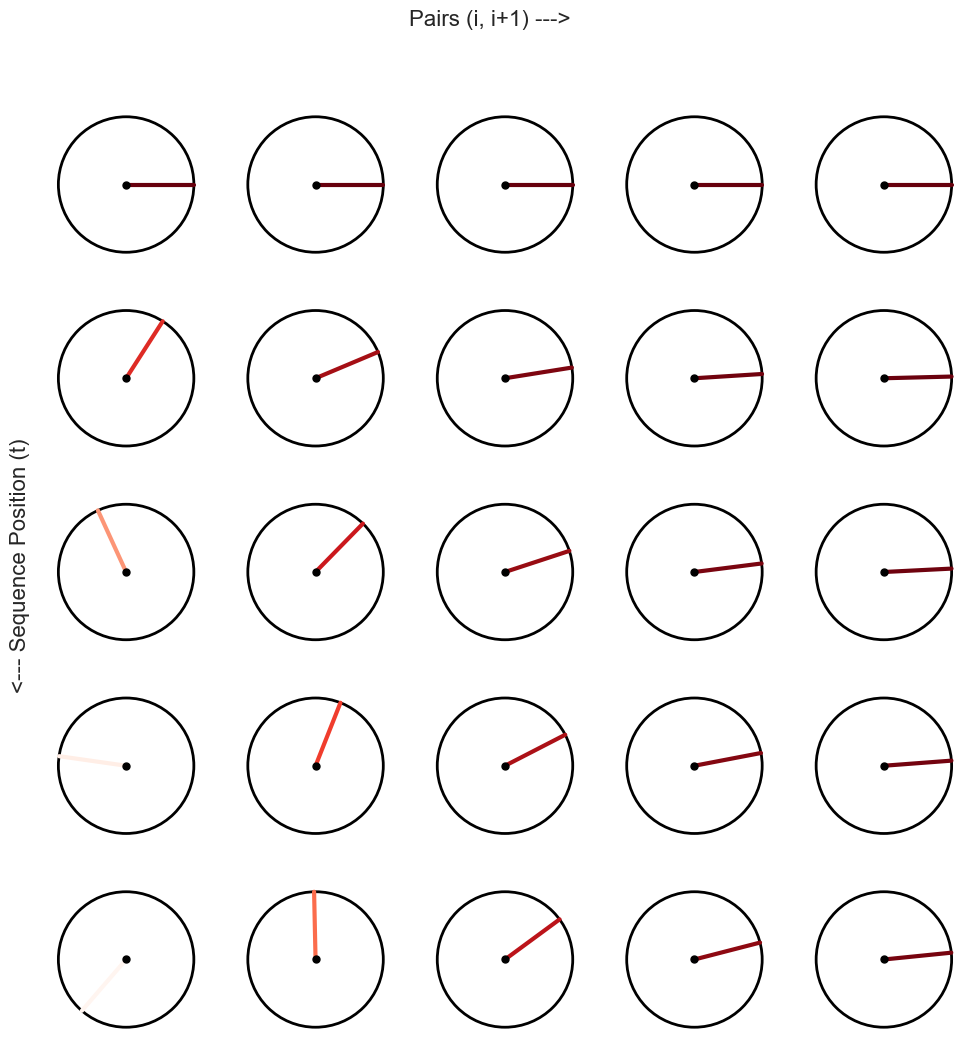

In [77]:
# Parameters for the grid
rows, cols = 5, 5  # Grid size
radius = 0.8  # Clock radius
total_clocks = rows * cols


# Create figure with a 5x10 grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Generate a colormap for the gradient based on the radian value
cmap = plt.get_cmap('Reds')  # Hue-based gradient for 0 to 2π

# Function to draw a clock with a single hand at a specific radian
def draw_radian_clock(i, j, x, y, angle, color):
    # Draw clock face
    clock_face = plt.Circle((0, 0), radius, edgecolor='black', facecolor='white', lw=2)
    ax = axes[i,j]
    ax.add_patch(clock_face)

    # Plot radian markers (0, π/2, π, 3π/2, 2π)
    #radian_markers = [(jnp.pi / 2, r"$\frac{\pi}{2}$"), 
    #                  (jnp.pi, r"$\pi$"), (3 * jnp.pi / 2, r"$\frac{3\pi}{2}$"), (2 * jnp.pi, r"$2\pi$")]
    
    #for marker_angle, label in radian_markers:
    #    x = jnp.cos(marker_angle)
    #    y = jnp.sin(marker_angle)
        #ax.text(x * 0.95, y * 0.95, label, ha='center', va='center', fontsize=16, fontweight='bold')

    #ax.text(x * 0.95 + 0.2 , y * 0.95 + 0.2, f"({i}, {j})", ha='center', va='center', fontsize=12, fontweight='bold')
    # Draw the hand extending to the edge of the circle
    ax.plot([0, radius * jnp.cos(angle)], [0, radius * jnp.sin(angle)], lw=3, color=color)

    # Center point
    ax.plot(0, 0, 'o', markersize=5, color='black')

    # Configure axis
    ax.set_aspect('equal')
    ax.axis('off')

# Populate the grid with clocks showing radian angles
for i in range(rows):
    for j in range(cols):
        # Compute the angle in radians for this clock (normalized between 0 and 2π)
        theta, x = get_embedding_value(i, 2*j)
        _, y = get_embedding_value(i, 2*j+1)

        # Get a color from the colormap based on the normalized angle
        color = cmap(1 - theta / jnp.pi)

        # Draw the clock with a single hand
        draw_radian_clock(i, j, x, y, theta, color)


# Set a single x-axis label for the entire grid
fig.text(0.5, 0.95, "Pairs (i, i+1) --->", ha='center', fontsize=16)

# Set a single y-axis label for the entire grid (optional)
fig.text(0.1, 0.5, "<--- Sequence Position (t)", va='center', rotation='vertical', fontsize=16)

plt.show()

